In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/jeremy/Documents/UMICH/Research/realsense-tracking'

In [2]:
try:
   import cPickle as pickle
except:
   import pickle
import re
import matplotlib.pyplot as plt
import open3d as o3d
from scipy import stats
import pandas as pd
from shapely.geometry import Polygon, box, Point
import shapely
import numpy as np
from landing.helper.o3d_util import create_linemesh_from_shapely, get_segments, _MeshTransmissionFormat, plot_polygons
from pathlib import Path
%matplotlib notebook  

## Plot Extracted Polygons

In [3]:
def flip_columns(array):
    array[:, [1, 0]] = array[:, [0, 1]]
    return array
def handle_multipolygon(polygon):
    if polygon.type == 'MultiPolygon':
        poly = None
        max_area = 0.0
        for geom in polygon.geoms:
            if geom.area > max_area:
                max_area = geom.area
                poly = geom
        return poly
    else:
        return polygon

def flip_xy(polygon):
    polygon = handle_multipolygon(polygon)
    exterior = flip_columns(np.array(polygon.exterior))
    holes = []
    for hole in polygon.interiors:
        holes.append(flip_columns(np.array(hole)))
    poly = Polygon(shell=exterior, holes=holes)
    return poly

def adjust_axes(ax):
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel("Y (m)")
    ax.set_ylabel("X (m)")
    ax.invert_yaxis()
    ax.invert_xaxis()
    


def parse_timings(fname):
    regex_str = "Volume Integration took: (\d*[.]\d*)"
    p = re.compile(regex_str)
    integration_times = []
    with open(fname, 'r') as fh:
        for line in fh:
            a = p.search(line)
            if a is not None:
                integration_times.append(float(a.groups()[0]))
    return np.array(integration_times)

In [4]:
data_dir = Path("assets/data/analysis")
saved = [data_dir / f"man_{i+1}.pkl" for i in range(5)]
data = [pickle.load(open(save, 'rb')) for save in saved]
for dat in data:
    dat['mesh'] = dat['mesh'].create_mesh()
# T265 Initialized to far forward on 4th run
data[3]['polygon'] = shapely.affinity.translate(data[3]['polygon'], xoff=0.1)

In [5]:
work_space = box(-1.75, -1.75, 1.75, 1.75)
small_box = box(0, 0,0.158, 0.254)
small_box = shapely.affinity.translate(small_box, xoff=1.21, yoff=1.0)

phantom_box = box(0, 0,0.362, 0.387)
phantom_box = shapely.affinity.translate(phantom_box, xoff=-1.15, yoff=.72)

medium_box = box(0, 0,.24, .42)
medium_box = shapely.affinity.translate(medium_box, xoff=-1.1, yoff=-.889)

ladder = box(0, 0, .43, .66)
ladder = shapely.affinity.translate(ladder, xoff=.1, yoff=.5)
ladder = shapely.affinity.rotate(ladder, angle=65, origin='centroid')

ladder_cutout = box(0, 0, .43, .33)
ladder_cutout = ladder_cutout.buffer(-0.1)
ladder_cutout = shapely.affinity.translate(ladder_cutout, xoff=-.2, yoff=.8)
ladder_cutout = shapely.affinity.rotate(ladder_cutout, angle=65, origin='centroid')

ladder = ladder.difference(ladder_cutout)

work_space_holes = work_space.difference(small_box).difference(phantom_box).difference(medium_box).difference(ladder)

for dat in data:
    dat['polygon_clipped'] = dat['polygon'].intersection(work_space)


## Plot Workspace

<IPython.core.display.Javascript object>


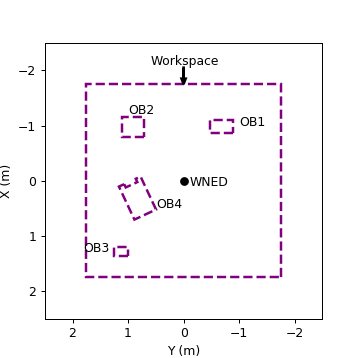

In [6]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
# plot_polygons([data[0]['polygon_clipped']], ax)
# plot_polygons([data[1]['polygon_clipped']], ax, shell_color='red', hole_color='red')
plot_polygons([flip_xy(work_space_holes)],ax, shell_color='purple', hole_color='purple', linestyle='dashed')
# plot_polygons([flip_xy(ladder_cutout)],ax, shell_color='red', hole_color='red')
adjust_axes(ax)
ax.scatter(0,0, c='k')
ax.text(-0.1,0.1, "WNED")
ax.text(-1, -1, "OB1")
ax.text(1, -1.2, "OB2")
ax.text(1.8, 1.3, "OB3")
ax.text(0.5, 0.5, "OB4")
ax.text(0.6, -2.1, "Workspace")
ax.arrow(0, -2.05, 0, 0.2, head_width=0.075, head_length=0.1, fc='k', ec='k', linewidth=2.0)
plt.savefig("assets/images/workspace_plot.pdf", bbox_inches='tight')

## Plot Polygons

<IPython.core.display.Javascript object>


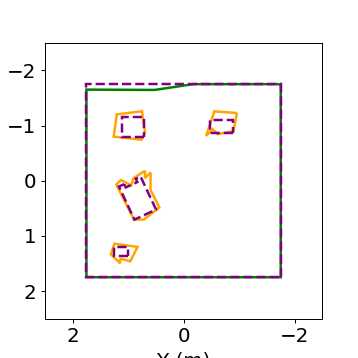

<IPython.core.display.Javascript object>


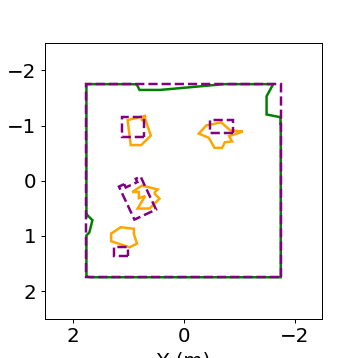

<IPython.core.display.Javascript object>


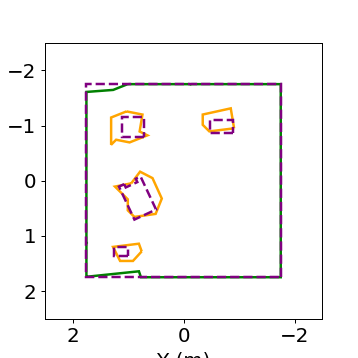

<IPython.core.display.Javascript object>


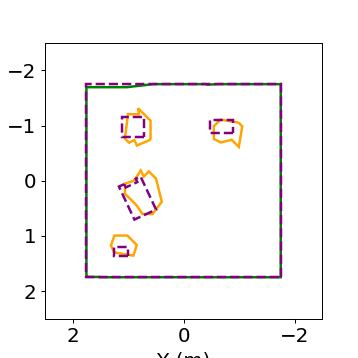

<IPython.core.display.Javascript object>


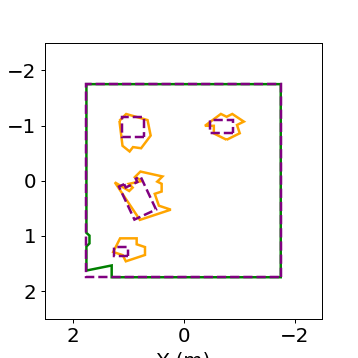

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
for i, dat in enumerate(data):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    plot_polygons([flip_xy(dat['polygon_clipped'])], ax)
    plot_polygons([flip_xy(work_space_holes)],ax, shell_color='purple', hole_color='purple', linestyle='dashed')
    adjust_axes(ax)
    fig.savefig(f"assets/images/man_poly_{i+1}.pdf", bbox_inches='tight')

In [181]:
for dat in data:
    dat['iou'] = dat['polygon_clipped'].intersection(work_space_holes).area / (dat['polygon_clipped'].union(work_space_holes).area)
    print(f"IOU: {dat['iou']:.3f} ")

ious = [dat['iou'] for dat in data]
print(f"Mean IOU: {np.mean(ious):.3f}")
print(stats.describe(ious))

IOU: 0.955 
IOU: 0.923 
IOU: 0.944 
IOU: 0.945 
IOU: 0.942 
Mean IOU: 0.942
DescribeResult(nobs=5, minmax=(0.9231580764793323, 0.9553303666718954), mean=0.9420077119358389, variance=0.00013691049161757902, skewness=-0.748779574624851, kurtosis=-0.3681565911444449)


## Execution Timing

In [22]:
integration_server_sbc_logs = [data_dir / f"sbc/rs-integrate-server_man_{i+1}.log" for i in range(5)]
integration_times_sbc = [np.array(parse_timings(log_file)) for log_file in integration_server_sbc_logs]
all_integration_times_sbc = np.concatenate(integration_times_sbc)

integration_server_desktop_logs = [data_dir / f"desktop/rs-integrate-server_man_{i+1}.log" for i in range(5)]
integration_times_desktop = [np.array(parse_timings(log_file)) for log_file in integration_server_desktop_logs]
all_integration_times_desktop = np.concatenate(integration_times_desktop)

def print_stats(all_times, times_section, name='SBC',):
    print(name)
    print(stats.describe(all_times))
    details = [dict(mean=np.mean(times), count=np.count_nonzero(times)) for times in times_section]
    print(details)
    print()

print_stats(all_integration_times_sbc, integration_times_sbc, "SBC")
print_stats(all_integration_times_desktop, integration_times_desktop, "Desktop")

SBC
DescribeResult(nobs=557, minmax=(1.899, 150.916), mean=26.138253141831242, variance=983.0303971102644, skewness=1.647348244825672, kurtosis=1.8061383249138512)
[{'mean': 27.069634782608695, 'count': 115}, {'mean': 21.066654205607477, 'count': 107}, {'mean': 25.731363636363636, 'count': 110}, {'mean': 26.497385245901636, 'count': 122}, {'mean': 30.37607766990291, 'count': 103}]

Desktop
DescribeResult(nobs=559, minmax=(0.852, 4.753), mean=2.497939177101968, variance=0.24757699987817466, skewness=0.1583323099606422, kurtosis=1.1678500626522652)
[{'mean': 2.558902654867257, 'count': 113}, {'mean': 1.897605504587156, 'count': 109}, {'mean': 2.641074074074074, 'count': 108}, {'mean': 2.5738000000000003, 'count': 125}, {'mean': 2.8210769230769235, 'count': 104}]



In [44]:
df = pd.read_csv(data_dir / 'alg_timings.csv')
df['t_polygon'] = df['t_polylidar_planepoly'] + df['t_fastga_total'] + df['t_bilateral']
df = df[['t_mesh_extraction', 't_polygon','t_polylidar_filter' ,'t_polylabel', 'computer']]
df.groupby('computer').agg(['mean','std'])

t_mesh_extraction            t_polygon           t_polylidar_filter  \
                      mean       std       mean       std               mean   
computer                                                                       
desktop            17.7308  3.078190   6.861540  0.978815          12.803647   
odyssey            50.2006  8.733345  17.970605  1.667306          37.199716   

                    t_polylabel            
                std        mean       std  
computer                                   
desktop    5.100138    0.110146  0.017277  
odyssey   11.455117    0.237012  0.052093

## Mesh Visualization

In [71]:
import open3d as o3d
def save_view_point(vis, filename=r"assets/data/o3d_view_default.json"):
    param = vis.get_view_control().convert_to_pinhole_camera_parameters()
    print("Uncommnet to save file. Disabled to prevent accidently overwriting")
#     o3d.io.write_pinhole_camera_parameters(filename, param)


def load_view_point(vis, filename=r"assets/data/o3d_view_default.json"):
    ctr = vis.get_view_control()
    param = o3d.io.read_pinhole_camera_parameters(filename)
    ctr.convert_from_pinhole_camera_parameters(param)
    
def add_column(array, z_value):
    ones = np.ones((array.shape[0], 1)) * z_value
    stacked = np.column_stack((array, ones))
    return stacked

def get_inscribed_circle_polygon(point, dist, mesh):  
    
    p1 = Point(point)
    p2 = p1.buffer(dist, resolution=16)
    coords = np.array(p2.exterior.coords)
    # get the exact z-coord for the circle using kd tree
    pcd = o3d.geometry.PointCloud(mesh.vertices)
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    new_points = []
    for i in range(coords.shape[0]):
        point_planar = coords[i,:]
        [_, idx, _]  = pcd_tree.search_knn_vector_3d([point_planar[0], point_planar[1], point[2]], 1)
        close_point = pcd.points[idx[0]]
        new_points.append([point_planar[0], point_planar[1], close_point[2]])
        
    circle = Polygon(new_points)
    return circle
    
key_to_callback = {ord("."):save_view_point, ord(","):load_view_point}

In [178]:
run = 2

pkl_data = data[run]
integrated_polygon = pkl_data['polygon']
integrated_touchdown_point = pkl_data['tp']
tp_dist = pkl_data['tp_dist']
o3d_mesh = pkl_data['mesh']



axis_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.2).translate([0,0,-0.1])
geoms = []
if integrated_polygon:
    line_meshes = create_linemesh_from_shapely(integrated_polygon)
    geoms.extend(get_segments(line_meshes))

if integrated_touchdown_point is not None and integrated_touchdown_point[0] != 0.0:
    tp_poly = get_inscribed_circle_polygon(integrated_touchdown_point, tp_dist, o3d_mesh)
    tp = create_linemesh_from_shapely(tp_poly, color=(0,0, 1.0))
    geoms.extend(get_segments(tp))
o3d.visualization.draw_geometries_with_key_callbacks([o3d_mesh, axis_frame, *geoms], 
                                                     key_to_callback=key_to_callback,width=800, height=600)